In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def non_markovian_midprice(inital_prices, 
                           permenant_price_impact_func, 
                           nu_vals,
                           drift_kernel_function, 
                           vol_kernel_function,
                           dt, 
                           rng,
                           num_paths,
                           num_timesteps,
                           sigma):
    
    noise_process = rng.normal(0,1, size=(num_timesteps, num_paths))

    prices = []
    for super_timestep in range(0, num_timesteps):
        final_time = super_timestep*dt

        permenant_price_impact_vals = permenant_price_impact_func(nu_vals[:super_timestep])

        # This gives K1(s, t) for s<=t to integrate over
        kernel_vals = np.array([drift_kernel_function(timestep*dt, final_time) for timestep in range(super_timestep)]) 
        kernel_integrand = kernel_vals.reshape(-1, 1) * permenant_price_impact_vals * dt
        # We do a vstack as the axis=1 are the batches
        kernel_integrand = np.vstack([inital_prices, kernel_integrand])
        kernel_integral = np.sum(kernel_integrand, axis=0)

        # This gives K2(s, t) for s<=t to integrate over
        kernel_vals_vol = np.array([vol_kernel_function(timestep*dt, final_time) for timestep in range(super_timestep)]).reshape(-1, 1)
        kernel_integrand_vol = sigma*kernel_vals_vol*(dt**0.5)*noise_process[:super_timestep, :]
        kernel_integral_vol = np.sum(kernel_integrand_vol, axis=0)
        
        s_t = kernel_integral + kernel_integral_vol

        prices.append(s_t)
    
    prices = np.vstack(prices)
    
    return prices, noise_process

In [20]:
rng = np.random.default_rng(123)

# num_paths = config.num_paths
# num_timesteps = config.num_timesteps
# final_time = config.final_time
# initial_price = config.initial_price
# decomp_dim = config.decomp_dim
# num_episodes = config.num_episodes
# batch_size = config.batch_size
# learning_rate = config.learning_rate

num_paths = 100
num_timesteps = 1000
final_time = 1
initial_price = 1
decomp_dim = 10
num_episodes = 10_000
batch_size = 1
dt = final_time / num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

kappa_true = 1
# permenant_price_impact_func = lambda x: kappa_true * x
permenant_price_impact_func = lambda x: kappa_true * np.sign(x) * np.sqrt(np.abs(x))

# kernel_function = lambda x,y: (np.abs((x-y)+1e-3)**(0.51-1))
drift_kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
vol_kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
# kernel_function = lambda x, y: np.exp(-np.abs((x - y)))
K0 = drift_kernel_function(0, 0)

nu_vals = rng.integers(-80, 100, size=(num_timesteps, num_paths))
min_pi = kappa_true*nu_vals.min()
max_pi = kappa_true*nu_vals.max()

In [21]:
sigma_true = 0.01
sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    drift_kernel_function=drift_kernel_function,
    vol_kernel_function=vol_kernel_function,
    dt=dt,
    rng=rng,
    num_paths=num_paths,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

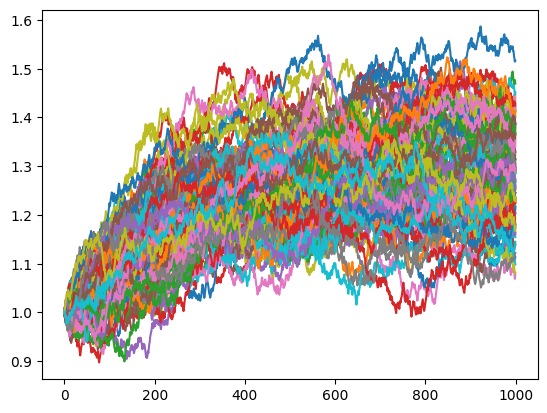

In [23]:
plt.plot(sim_prices)
plt.show()